In [15]:
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, periodogram
import xarray as xr

In [2]:
path_cmip6 = "/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/atmos_cmip_2deg_daily_3D/ts/daily/5yr"

ds_u = xr.open_mfdataset(f"{path_cmip6}/atmos_cmip_2deg_daily_3D.02*.ua.nc", use_cftime=True)
ds_v = xr.open_mfdataset(f"{path_cmip6}/atmos_cmip_2deg_daily_3D.02*.va.nc", use_cftime=True)

In [3]:
u850 = ds_u.ua.sel(lat=slice(-90,-30), plev19=850e2).load()
v850 = ds_v.va.sel(lat=slice(-90,-30), plev19=850e2).load()

period_low = 2.5 #same bounds for bandpass filter used in Meehl et al 2019
period_high = 6

lowcut = 1/period_high
highcut = 1/period_low

In [5]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='bandpass')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [6]:
u850_bp = np.zeros(u850.shape)
v850_bp = np.zeros(v850.shape)

for i in np.arange(np.shape(u850_bp)[1]):
    for j in np.arange(np.shape(u850_bp)[2]):
        test_u = u850[:,i,j]
        test_v = v850[:,i,j]
        u850_bp[:,i,j] = butter_bandpass_filter(test_u, lowcut, highcut, 1)
        v850_bp[:,i,j] = butter_bandpass_filter(test_v, lowcut, highcut, 1)

In [11]:
da = xr.DataArray(
    data=0.5*(u850_bp**2+v850_bp**2),
    dims=["time", "lat", "lon"],

    coords=dict(
        lon=(["lon"], ds_u.lon.data),
        lat=(["lat"], u850.lat.data),
        time=ds_u.time.data,
    ),

    attrs=dict(
        description="850 hPa EKE",
        units="m2 s-2",

    ),
)

In [16]:
sEKE = da.groupby(da.time.dt.season).mean(skipna=True)

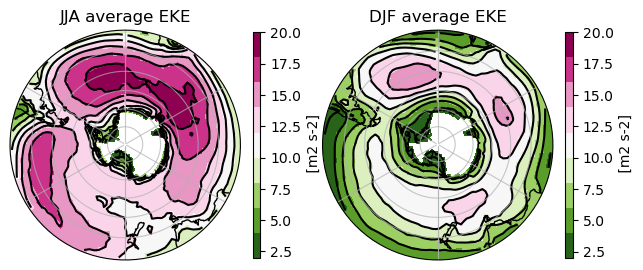

In [56]:
# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)


fig, axs = plt.subplots(nrows=1, ncols=2,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs = axs.flatten()

sEKE.sel(season="JJA").plot(ax=axs[0], transform=ccrs.PlateCarree(),
                                   cbar_kwargs = {'fraction': 0.03,
                                                    'aspect': 30,
                                                    'shrink': 0.7},
                                   vmin=2, vmax=20, extend="neither",
                                   cmap=plt.get_cmap("PiYG_r", 9))
CS1 = sEKE.sel(season="JJA").plot.contour(ax=axs[0], transform=ccrs.PlateCarree(),
                                   levels=np.arange(2,22,2), colors=('k',))
axs[0].set_title("JJA average EKE")

sEKE.sel(season="DJF").plot(ax=axs[1], transform=ccrs.PlateCarree(),
                                   cbar_kwargs = {'fraction': 0.03,
                                                    'aspect': 30,
                                                    'shrink': 0.7},
                                   vmin=2, vmax=20, extend="neither",
                                   cmap=plt.get_cmap("PiYG_r", 9))
CS2 = sEKE.sel(season="DJF").plot.contour(ax=axs[1], transform=ccrs.PlateCarree(),
                                   levels=np.arange(2,22,2), colors=('k',))
axs[1].set_title("DJF average EKE")

for i in np.arange(2):
    axs[i].set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.tight_layout()
plt.savefig('/work/Katherine.Turner/CM4_storms/analysis_figures/')